In [3]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest   # para seleccionar atributos de forma univariada (filtros)
from sklearn.feature_selection import chi2   # estadististica para evaluar la importancia de atributos en relacion al target
from sklearn.feature_selection import RFE    # metodo recursive featute elimination
from sklearn.decomposition import PCA        # para transformacion PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # para modelos discriminantes lineales
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB   # para modelos Naive Bayes
from sklearn.linear_model import LogisticRegression # para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier     # para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier  # para modelos  Knn
from sklearn.svm import SVC   # para modelos SVM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split  # para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold  # para partir la data en k-folds
from sklearn.model_selection import cross_val_score   # para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, balanced_accuracy_score # para manejar metricas de desempeño
from sklearn.metrics import classification_report  # para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix  # para manejar matrices de confusion
from sklearn.metrics import jaccard_score  # indice jacard

Lectura de datos

In [4]:
df = pd.read_csv('IGP_EstacionEMA_2018-2024_Dataset.csv',
                 engine='python',
                 on_bad_lines='skip')

# **Preprocesamiento de datos**

Verificando valores nulos

In [ ]:
df.isnull().sum()/df.shape[0] * 100

,0
FECHA_CORTE,0.000000
UBIGEO,0.000000
YY,0.000000
MM,0.000000
DY,0.000000
HH,0.000000
TT,0.930452
HR,0.930452
RR,0.930452
PP,0.930452


Eliminando los valores nulos de RR

In [5]:
df = df.loc[df['RR'].notnull()]

Actualización de los valores nulos

In [ ]:
df.isnull().sum()/df.shape[0] * 100

,0
FECHA_CORTE,0.0
UBIGEO,0.0
YY,0.0
MM,0.0
DY,0.0
HH,0.0
TT,0.0
HR,0.0
RR,0.0
PP,0.0


La variable target es RR, así que exploramos la distribución de sus datos

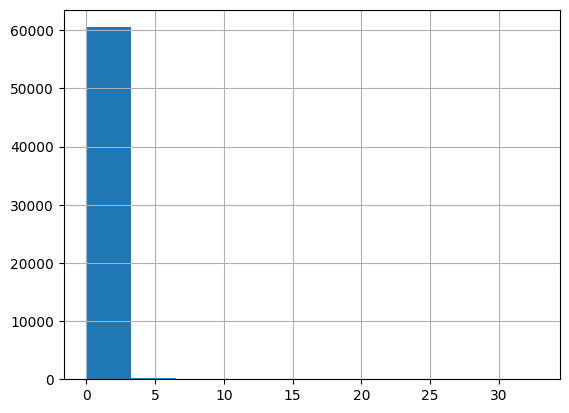

In [ ]:
df.RR.hist()
plt.show()

Se evidencia una desproporción en la distribución así que se aplica transformación logarítmica.

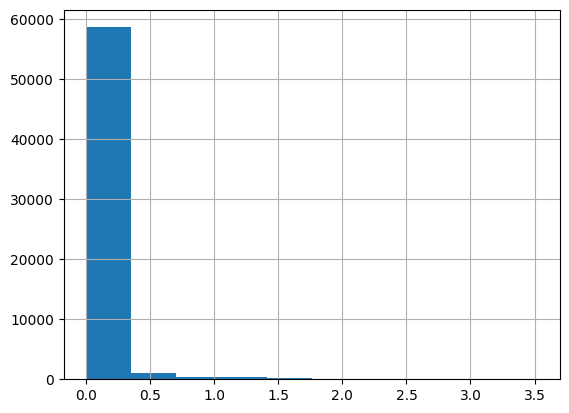

In [6]:
df['RR'] = np.log1p(df['RR'])  # log1p para evitar problemas con ceros
df.RR.hist()
plt.show()

Se convierte la variable target a 0 (si no hay precipitacion: RR <= 0) o si hay precipitación (RR > 0)

In [7]:
df['RR'] = np.where(df.RR<=0.0, 0.0, 1)

In [6]:
df.head()

,FECHA_CORTE,UBIGEO,YY,MM,DY,HH,TT,HR,RR,PP,FF,DD
0,20250530,120904,2018,1,1,0,7.66098,89.51500,1.0,687.40333,2.97943,145.64165
1,20250530,120904,2018,1,1,1,7.73552,90.29500,1.0,686.94167,1.70000,284.01833
2,20250530,120904,2018,1,1,2,7.57108,91.00500,1.0,686.67667,1.65667,63.06462
3,20250530,120904,2018,1,1,3,7.52045,89.73167,0.0,686.50000,1.13227,34.77467
4,20250530,120904,2018,1,1,4,7.13343,88.88167,1.0,686.60333,0.64763,72.41817


Codificación radial para las variables de HH, MM y DY ya que son cíclicas.

In [8]:
# Codificación cíclica para la hora
df['HH_sin'] = np.sin(2 * np.pi * df['HH'] / 24)
df['HH_cos'] = np.cos(2 * np.pi * df['HH'] / 24)

# Para el mes (MM)
df['MM_sin'] = np.sin(2 * np.pi * df['MM'] / 12)
df['MM_cos'] = np.cos(2 * np.pi * df['MM'] / 12)

# Para el día del mes (DY), si sabes que siempre es de 1 a 31
df['DY_sin'] = np.sin(2 * np.pi * df['DY'] / 31)
df['DY_cos'] = np.cos(2 * np.pi * df['DY'] / 31)

df.drop(columns=['HH','MM','DY'])

,FECHA_CORTE,UBIGEO,YY,TT,HR,RR,PP,FF,DD,HH_sin,HH_cos,MM_sin,MM_cos,DY_sin,DY_cos
0,20250530,120904,2018,7.66098,89.51500,1.0,687.40333,2.97943,145.64165,0.000000,1.000000,5.000000e-01,0.866025,2.012985e-01,0.97953
1,20250530,120904,2018,7.73552,90.29500,1.0,686.94167,1.70000,284.01833,0.258819,0.965926,5.000000e-01,0.866025,2.012985e-01,0.97953
2,20250530,120904,2018,7.57108,91.00500,1.0,686.67667,1.65667,63.06462,0.500000,0.866025,5.000000e-01,0.866025,2.012985e-01,0.97953
3,20250530,120904,2018,7.52045,89.73167,0.0,686.50000,1.13227,34.77467,0.707107,0.707107,5.000000e-01,0.866025,2.012985e-01,0.97953
4,20250530,120904,2018,7.13343,88.88167,1.0,686.60333,0.64763,72.41817,0.866025,0.500000,5.000000e-01,0.866025,2.012985e-01,0.97953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61363,20250530,120904,2024,10.27367,83.96833,1.0,685.78500,1.83233,163.55600,-0.965926,0.258819,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61364,20250530,120904,2024,9.81933,86.66000,0.0,686.46333,2.50250,270.63500,-0.866025,0.500000,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61365,20250530,120904,2024,9.39933,83.16717,1.0,687.03000,1.99017,267.03833,-0.707107,0.707107,-2.449294e-16,1.000000,-2.449294e-16,1.00000
61366,20250530,120904,2024,9.40133,79.27250,0.0,687.30000,2.06417,287.48833,-0.500000,0.866025,-2.449294e-16,1.000000,-2.449294e-16,1.00000


Separación del dataset

In [9]:
# separa el dataset en atributos (X)  y  target (y)
df = df.drop(columns=['FECHA_CORTE','UBIGEO','YY'])
array = df.values
X = df.drop(columns='RR')  # atributos
y = df['RR']    # target

# realiza el train-test split
vadid_fraction = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 48637 ejemplos. Validation: 12160 ejemplos


Obtención de train data con los distintos métodos de submuestreo y sobremuestreo.

In [10]:
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    ADASYN,
    RandomOverSampler,
    SVMSMOTE
)

from imblearn.under_sampling import (
    RandomUnderSampler,
    TomekLinks,
    EditedNearestNeighbours,
    OneSidedSelection,
    NeighbourhoodCleaningRule,
    NearMiss
)

from collections import Counter

In [11]:
# ------------------ Submuestreo y sobremuestreo ------------------

# ----- SOBREMUESTREO -----

# SMOTE
smote = SMOTE(random_state=seed)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)

# Borderline-SMOTE
borderline = BorderlineSMOTE(random_state=seed, kind='borderline-1')
X_res_bsmote, y_res_bsmote = borderline.fit_resample(X_train, y_train)

# ADASYN
adasyn = ADASYN(random_state=seed)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train, y_train)

# Random Oversampling
ros = RandomOverSampler(random_state=seed)
X_res_ros, y_res_ros = ros.fit_resample(X_train, y_train)

# SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X_train, y_train)

# ----- SUBMUESTREO -----

# Random UnderSampler
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Tomek Links
tomek = TomekLinks()
X_res_tomek, y_res_tomek = tomek.fit_resample(X_train, y_train)

# Edited Nearest Neighbors
enn = EditedNearestNeighbours(n_neighbors=3)
X_res_enn, y_res_enn = enn.fit_resample(X_train, y_train)

# One-Sided Selection (OSS)
oss = OneSidedSelection(random_state=seed)
X_train_OSS, y_train_OSS = oss.fit_resample(X_train, y_train)

# Neighborhood Cleaning Rule (NCL)
ncl = NeighbourhoodCleaningRule()
X_train_ncl, y_train_ncl = ncl.fit_resample(X_train, y_train)

# NearMiss
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X_train, y_train)

# ----- PRINT DE RESULTADOS -----

print("Tamaños tras resampling:")
print("SMOTE:", X_res_smote.shape, dict(Counter(y_res_smote)))
print("Borderline-SMOTE:", X_res_bsmote.shape, dict(Counter(y_res_bsmote)))
print("ADASYN:", X_res_adasyn.shape, dict(Counter(y_res_adasyn)))
print("Random Oversampling:", X_res_ros.shape, dict(Counter(y_res_ros)))
print("SVMSMOTE:", X_svm_smote.shape, dict(Counter(y_svm_smote)))

print("Random UnderSampler:", X_rus.shape, dict(Counter(y_rus)))
print("Tomek Links:", X_res_tomek.shape, dict(Counter(y_res_tomek)))
print("Edited Nearest Neighbors (ENN):", X_res_enn.shape, dict(Counter(y_res_enn)))
print("One-Sided Selection (OSS):", X_train_OSS.shape, dict(Counter(y_train_OSS)))
print("Neighborhood Cleaning Rule (NCL):", X_train_ncl.shape, dict(Counter(y_train_ncl)))
print("NearMiss:", X_nearmiss.shape, dict(Counter(y_nearmiss)))


Tamaños tras resampling:
SMOTE: (91160, 14) {0.0: 45580, 1.0: 45580}
Borderline-SMOTE: (91160, 14) {0.0: 45580, 1.0: 45580}
ADASYN: (91363, 14) {0.0: 45580, 1.0: 45783}
Random Oversampling: (91160, 14) {0.0: 45580, 1.0: 45580}
SVMSMOTE: (91160, 14) {0.0: 45580, 1.0: 45580}
Random UnderSampler: (6114, 14) {0.0: 3057, 1.0: 3057}
Tomek Links: (47583, 14) {0.0: 44526, 1.0: 3057}
Edited Nearest Neighbors (ENN): (43575, 14) {0.0: 40518, 1.0: 3057}
One-Sided Selection (OSS): (47121, 14) {0.0: 44064, 1.0: 3057}
Neighborhood Cleaning Rule (NCL): (43835, 14) {0.0: 40778, 1.0: 3057}
NearMiss: (6114, 14) {0.0: 3057, 1.0: 3057}


Gráfico comparativo de cuántas muestras resultan por clase con cada técnica

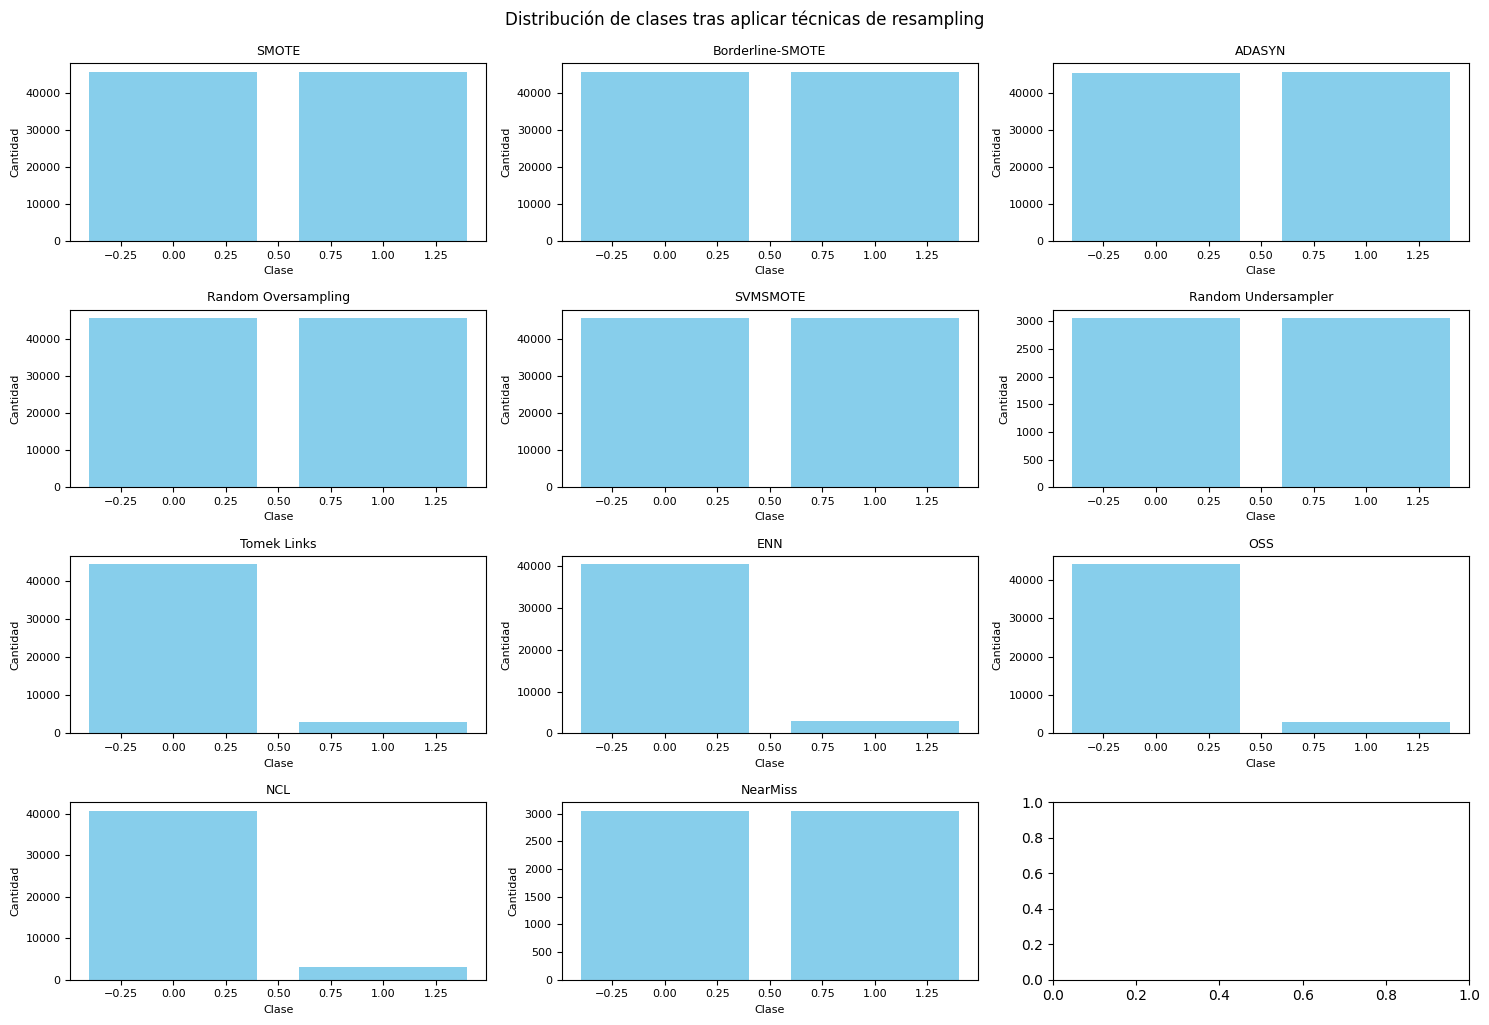

In [ ]:
# Diccionario con los nombres de cada técnica y sus etiquetas balanceadas
resampled_datasets = {
    "SMOTE": y_res_smote,
    "Borderline-SMOTE": y_res_bsmote,
    "ADASYN": y_res_adasyn,
    "Random Oversampling": y_res_ros,
    "SVMSMOTE": y_svm_smote,
    "Random Undersampler": y_rus,
    "Tomek Links": y_res_tomek,
    "ENN": y_res_enn,
    "OSS": y_train_OSS,
    "NCL": y_train_ncl,
    "NearMiss": y_nearmiss
}

# Gráfico de barras para cada técnica
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, (name, y_resampled) in enumerate(resampled_datasets.items()):
    counts = Counter(y_resampled)
    axes[i].bar(counts.keys(), counts.values(), color='skyblue')
    axes[i].set_title(name, fontsize=9)
    axes[i].set_xlabel("Clase", fontsize=8)
    axes[i].set_ylabel("Cantidad", fontsize=8)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.suptitle("Distribución de clases tras aplicar técnicas de resampling", fontsize=12, y=1.02)
plt.show()

Evalua diferentes algoritmos de ML en crossvalidacion sin técnicas de submuestreo.

In [12]:
algos = []
algos.append(('LogReg', LogisticRegression( solver='liblinear')))  #genera logistic regresors con solver liblinear
algos.append(('5NN', KNeighborsClassifier( n_neighbors=5))) #genera knn con 5 vecinos
algos.append(('10NN', KNeighborsClassifier( n_neighbors=10))) #genera knn con 5 vecinos
algos.append(('CART', DecisionTreeClassifier(max_depth=None ))) # genera DT sin restriccion de profundidad -> se va hasta el fondo osea overfitting
algos.append(('RF', RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None)))
algos.append(("AdaBoost", AdaBoostClassifier(n_estimators=60 , random_state=seed)))
algos.append(("GradBoost", GradientBoostingClassifier(n_estimators=60, random_state=7)))
algos.append(("LDA", LinearDiscriminantAnalysis()))

La evaluacion de cada algoritmo se realiza con los datos de training en estrategia de Crossvalidacion con 10-folds. Se usa el mismo particionamiento de folds en cada algoritmo a evaluar para asegurar una comparación justa.

La metrica de evaluacion es 'balanced_accuracy', esta es el promedio de recalls en cada clase ( recall(clase i) = proporcion correctamente clasificada como clase i del total de ejemplos de clase i ).

In [13]:
# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

In [ ]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))    #Esto es el accuracy

LogReg: 0.5990934935761719 (0.013955027369360802)
5NN: 0.5682502050860615 (0.011344656356601628)
10NN: 0.5296358977701571 (0.005044567981892242)
CART: 0.6572477530004053 (0.012638817423859037)
RF: 0.6244029614664699 (0.010919264409911396)
AdaBoost: 0.5591835174046678 (0.010150327908096692)
GradBoost: 0.6195040448245062 (0.011439570057457845)
LDA: 0.6247111844217438 (0.010645573043697704)


Boxplots de algoritmos

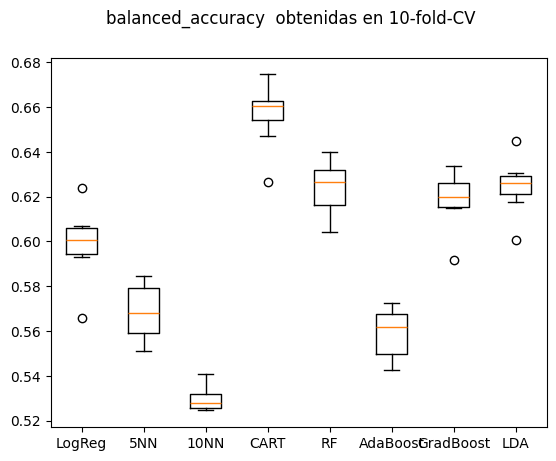

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure()
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Entrenamiento del modelo

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación

model = DecisionTreeClassifier(max_depth=None , class_weight='balanced')
# Solo para modelos que usan gradiente se puede hacer lo de class_weight
model.fit(X_train, y_train)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6461111618560468

Matriz de Confusión:
[[10944   480]
 [  490   246]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     11424
         1.0       0.34      0.33      0.34       736

    accuracy                           0.92     12160
   macro avg       0.65      0.65      0.65     12160
weighted avg       0.92      0.92      0.92     12160



# **Pruebas con sobremuestreo**

Evaluación de técnicas de sobremuestreo SMOTE y Borderline-Smote

In [ ]:
results_over = []
names_over = []
print("Smote:")
for algoname, algo in algos:
    cv_results1 = cross_val_score(algo, X_res_smote, y_res_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results1)
    names_over.append(algoname + ' - Smote')
    print("{}: {} ({})".format(algoname, cv_results1.mean(), cv_results1.std()))    #Esto es el accuracy

print("Borderline-Smote:")
for algoname, algo in algos:
    cv_results2 = cross_val_score(algo, X_res_bsmote, y_res_bsmote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results2)
    names_over.append(algoname + ' - Borderline-Smote:')
    print("{}: {} ({})".format(algoname, cv_results2.mean(), cv_results2.std()))    #Esto es el accuracy

Smote:
LogReg: 0.8236628275908314 (0.0027462371201902583)
5NN: 0.9200623414053414 (0.0027776148535465536)
10NN: 0.9084731998418321 (0.0027047995624887035)
CART: 0.9461462783955155 (0.002762213163792666)
RF: 0.9753567068592659 (0.0012069894348937793)
AdaBoost: 0.8747041017646147 (0.004596472267083905)
GradBoost: 0.9259730842000714 (0.002801104596331196)
LDA: 0.825793966307954 (0.0018990220141129484)
Borderline-Smote:
LogReg: 0.851570862197723 (0.0026313186019739972)
5NN: 0.9334420978692044 (0.0024204684404033495)
10NN: 0.9220612364621351 (0.00251623136958808)
CART: 0.9469663626387996 (0.002203659717090831)
RF: 0.9756367428406755 (0.00104155145971177)
AdaBoost: 0.8868355895795128 (0.004011943787296536)
GradBoost: 0.926817712876946 (0.0038710959315769165)
LDA: 0.8488497124959743 (0.0027194107930841776)


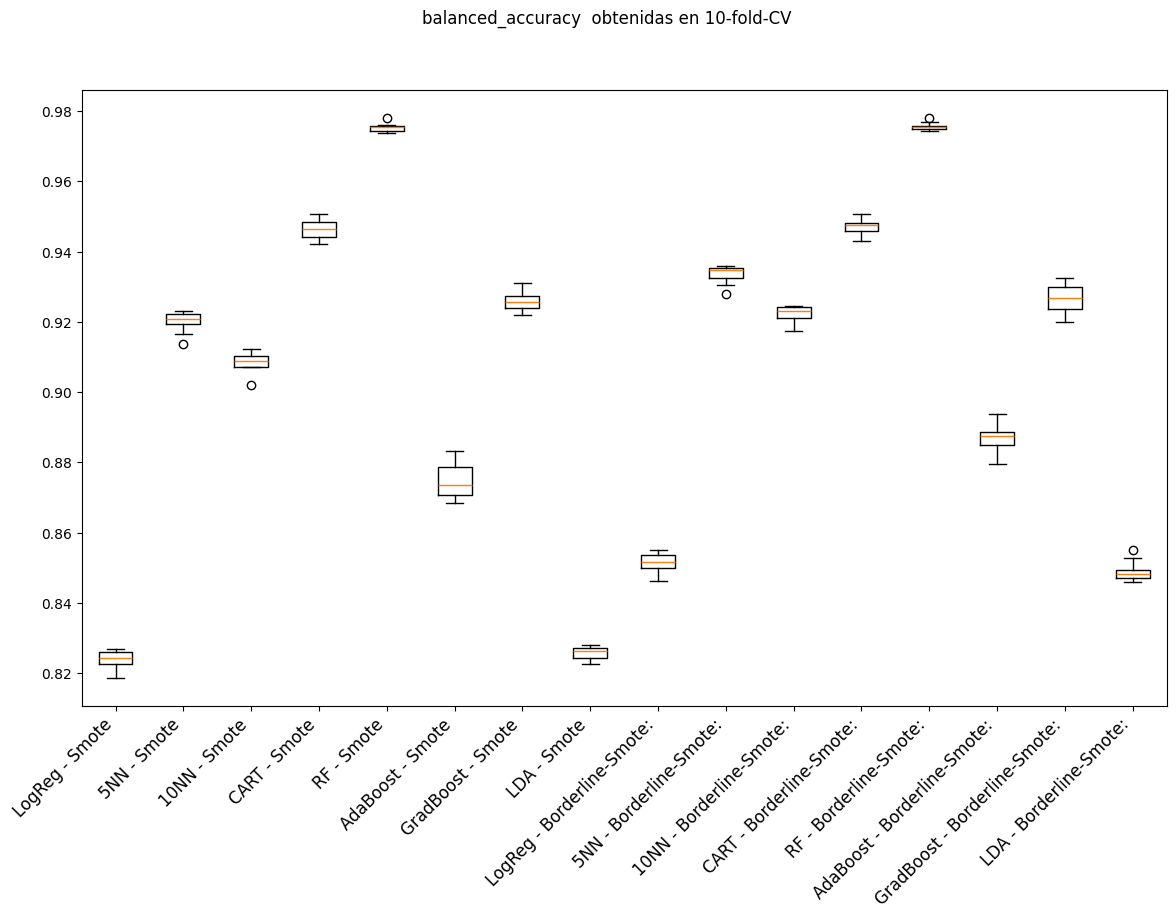

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_over)
plt.show()

Evaluación de técnicas de sobremuestreo Adasyn y RandomOverSampler

In [ ]:
# ADASYN
print("\nADASYN:")
for algoname, algo in algos:
    cv_results3 = cross_val_score(algo, X_res_adasyn, y_res_adasyn, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results3)
    names_over.append(f"{algoname} - ADASYN")
    print(f"{algoname}: {cv_results3.mean()} ({cv_results3.std()})")

# RandomOverSampler
print("\nRandomOverSampler:")
for algoname, algo in algos:
    cv_results4 = cross_val_score(algo, X_res_ros, y_res_ros, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results4)
    names_over.append(f"{algoname} - ROS")
    print(f"{algoname}: {cv_results4.mean()} ({cv_results4.std()})")


ADASYN:
LogReg: 0.8113973475819009 (0.0033193968533978446)
5NN: 0.9152837235700761 (0.002955267586865145)
10NN: 0.9028976982602039 (0.0037905064643138234)
CART: 0.9479740168430457 (0.002365440699329327)
RF: 0.9753640891384368 (0.0014633094972578567)
AdaBoost: 0.8686630810595236 (0.00597836746740388)
GradBoost: 0.92245020106249 (0.0032932759956037566)
LDA: 0.8140064888353145 (0.0024356289292950094)

RandomOverSampler:
LogReg: 0.8091998987184359 (0.002939384430861114)
5NN: 0.9394995639037205 (0.0025027906613278826)
10NN: 0.9092860299861678 (0.0031160517912738788)
CART: 0.9774931589873969 (0.0013593027712654271)
RF: 0.9930229843157241 (0.0010874886526612692)
AdaBoost: 0.8091191196503533 (0.003944522906348197)
GradBoost: 0.8336535548804733 (0.004023858005170579)
LDA: 0.8084485036341003 (0.002823415431050796)


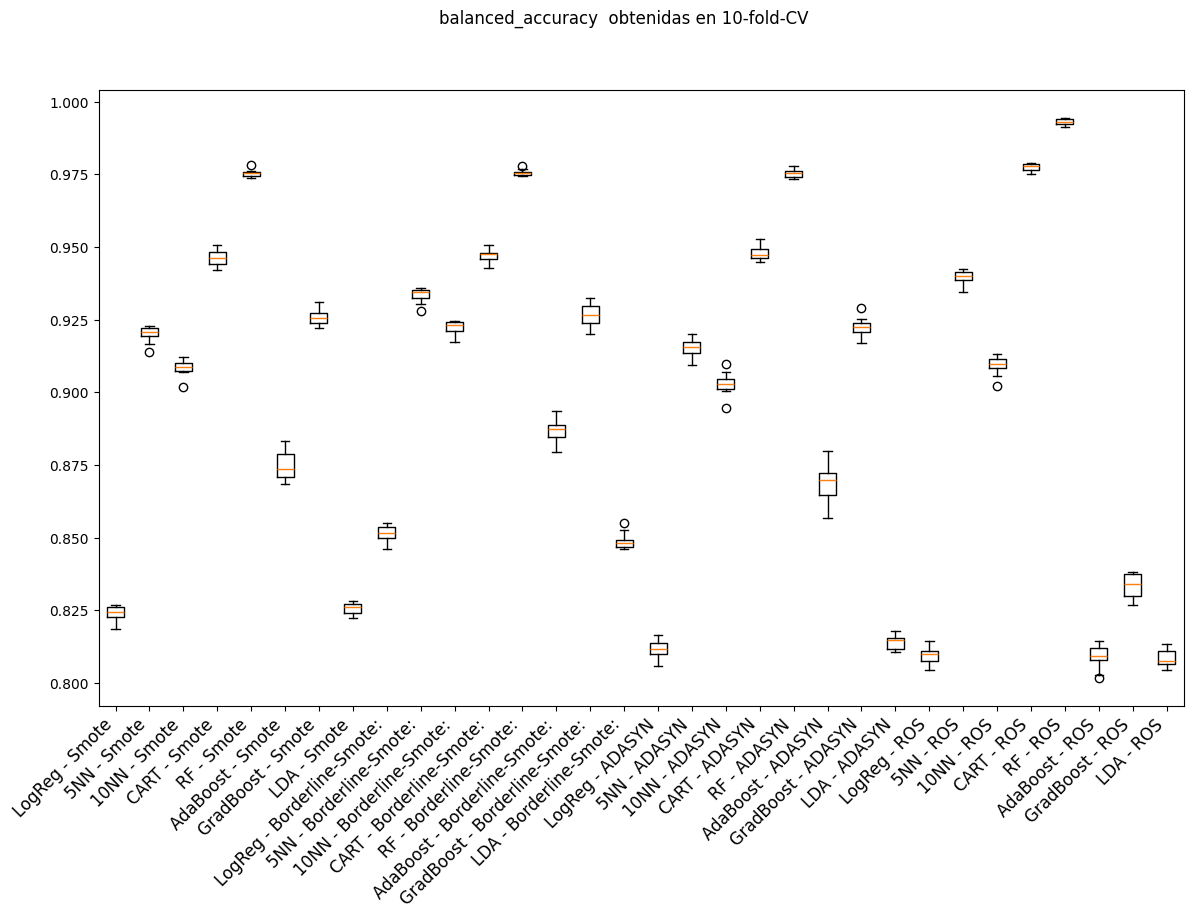

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_over)
plt.show()

Evaluación de técnicas de sobremuestreo Svsmote

In [ ]:
print("\nSVSMOTE:")
for algoname, algo in algos:
    cv_results5 = cross_val_score(algo, X_svm_smote, y_svm_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results5)
    names_over.append(f"{algoname} - SVSMOTE")
    print("{}: {} ({})".format(algoname, cv_results5.mean(), cv_results5.std()))


SVSMOTE:
LogReg: 0.867262152554272 (0.002230967423044332)
5NN: 0.9378036768947908 (0.0028150502710206616)
10NN: 0.9285978022635606 (0.0029317682272336975)
CART: 0.9446106352223758 (0.0021234771296423875)
RF: 0.9749983531583721 (0.0014185855575834785)
AdaBoost: 0.8972732130422278 (0.004215021172259364)
GradBoost: 0.9292588985438641 (0.0030559100025221143)
LDA: 0.8648786084135957 (0.002326604632834053)


# **RESULTADO DE PRUEBAS DE ALGORITMOS + TÉCNICAS DE SOBREMUESTREO**

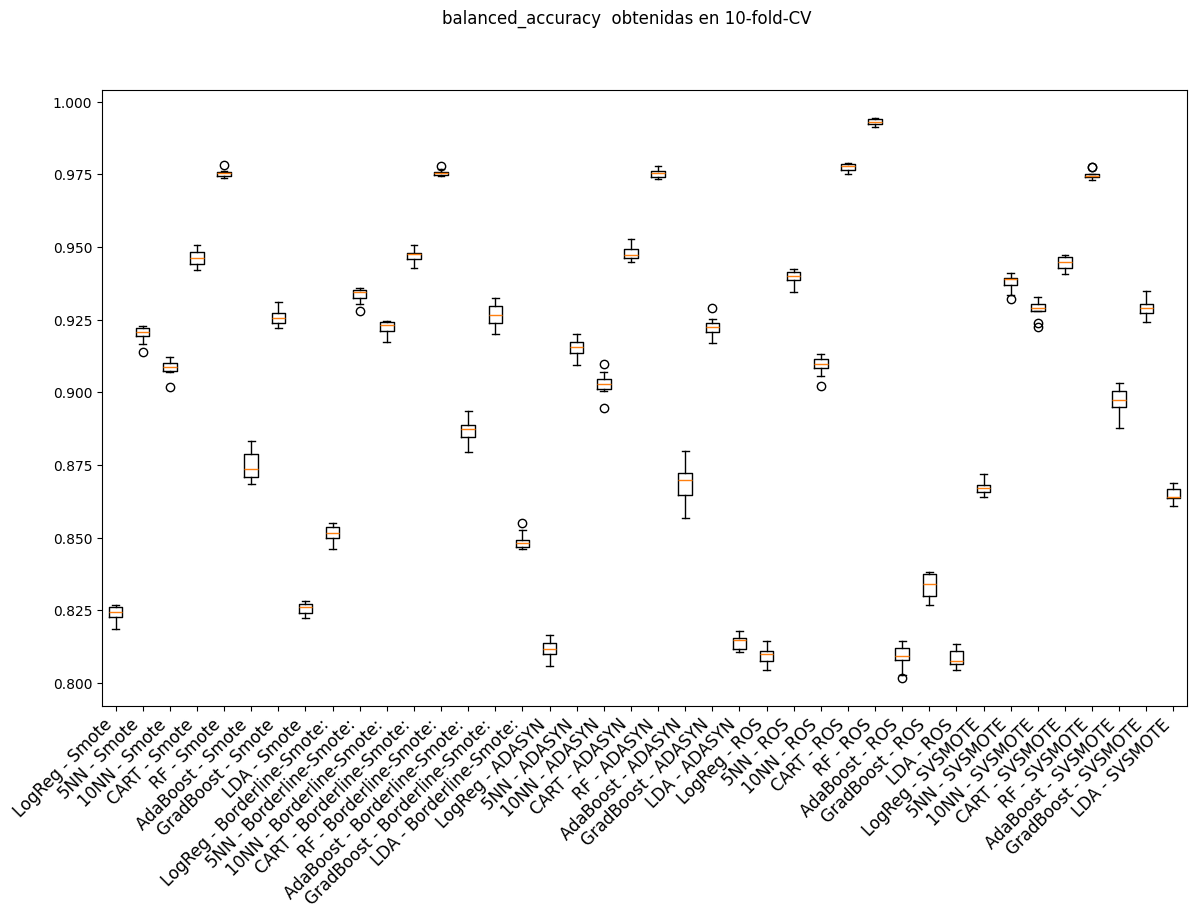

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_over)
plt.show()

Según el boxplot, la mejor combinación fue Random Forest + ROS, por lo que se procede a entrenar el modelo.

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ROS
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1)
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6593270460358056

Matriz de Confusión:
[[11277   147]
 [  492   244]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     11424
         1.0       0.62      0.33      0.43       736

    accuracy                           0.95     12160
   macro avg       0.79      0.66      0.70     12160
weighted avg       0.94      0.95      0.94     12160



# **Pruebas con submuestreo**

Evaluación de técnicas de submuestreo Random Under Sampler y Tonnek links

In [ ]:
results_under = []
names_under = []
print("\nRUS:")
for algoname, algo in algos:
    cv_results_rus = cross_val_score(algo, X_rus, y_rus, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_rus)
    names_under.append(f"{algoname} - RUS")
    print("{}: {} ({})".format(algoname, cv_results_rus.mean(), cv_results_rus.std()))

print("\nTomek Links:")
for algoname, algo in algos:
    cv_results_tomek = cross_val_score(algo, X_res_tomek, y_res_tomek, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_tomek)
    names_under.append(f"{algoname} - Tomek")
    print("{}: {} ({})".format(algoname, cv_results_tomek.mean(), cv_results_tomek.std()))

print("\nENN:")
for algoname, algo in algos:
    cv_results_enn = cross_val_score(algo, X_res_enn, y_res_enn, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_enn)
    names_under.append(f"{algoname} - ENN")
    print("{}: {} ({})".format(algoname, cv_results_enn.mean(), cv_results_enn.std()))



RUS:
LogReg: 0.8042676699140076 (0.012745872196537526)
5NN: 0.7590277117029568 (0.013905536481799504)
10NN: 0.7608391882474732 (0.015009033069598462)
CART: 0.7441974218963087 (0.015003999967417121)
RF: 0.8200296091378018 (0.009268396903029904)
AdaBoost: 0.7978202003547326 (0.011689773990855256)
GradBoost: 0.8120121649485874 (0.010020351687515265)
LDA: 0.8038858927812358 (0.012019703270020988)

Tomek Links:
LogReg: 0.6113848629189729 (0.008853371424432021)
5NN: 0.585847529338704 (0.016831599960588976)
10NN: 0.5423180020279521 (0.011001858763431741)
CART: 0.6694044531957123 (0.016489911175001985)
RF: 0.6387065644366856 (0.01485696680269313)
AdaBoost: 0.5698211242581783 (0.013493941241746963)
GradBoost: 0.634895984293049 (0.010831837573602756)
LDA: 0.636665711919162 (0.013951309190397288)

ENN:
LogReg: 0.6673211672002026 (0.012775641357223576)
5NN: 0.6723045125396532 (0.015841183708343073)
10NN: 0.6202008165000084 (0.013736210919851829)
CART: 0.7143767212392154 (0.010441572988284714)
RF:

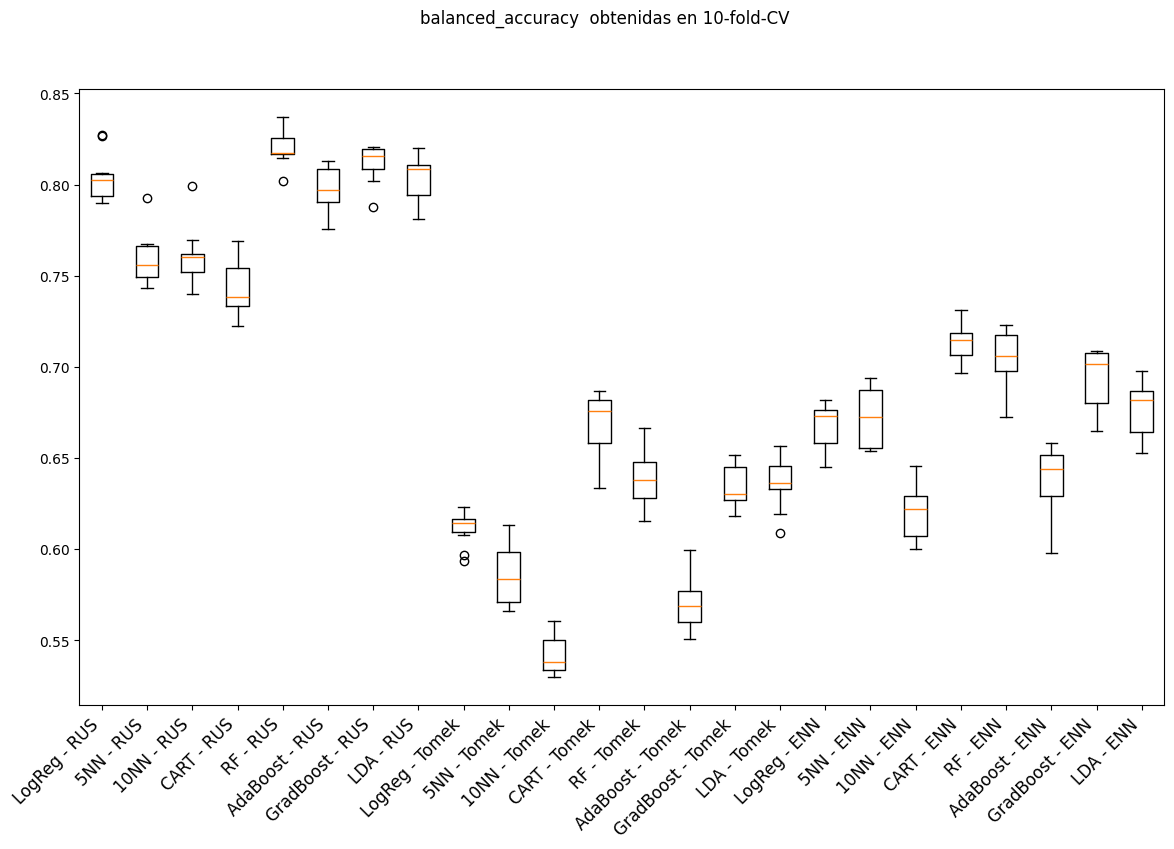

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_under)
ax.set_xticklabels(names_under, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_under)
plt.show()

In [ ]:
print("\nOSS:")
for algoname, algo in algos:
    cv_results_oss = cross_val_score(algo, X_train_OSS, y_train_OSS, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_oss)
    names_under.append(f"{algoname} - OSS")
    print("{}: {} ({})".format(algoname, cv_results_oss.mean(), cv_results_oss.std()))

print("\nNCL:")
for algoname, algo in algos:
    cv_results_ncl = cross_val_score(algo, X_train_ncl, y_train_ncl, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_ncl)
    names_under.append(f"{algoname} - NCL")
    print("{}: {} ({})".format(algoname, cv_results_ncl.mean(), cv_results_ncl.std()))

print("\nNear Miss:")
for algoname, algo in algos:
    cv_results_near_miss = cross_val_score(algo, X_nearmiss, y_nearmiss, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_near_miss)
    names_under.append(f"{algoname} - Near Miss")
    print("{}: {} ({})".format(algoname, cv_results_near_miss.mean(), cv_results_near_miss.std()))


OSS:
LogReg: 0.6118567052993629 (0.016047208569018732)
5NN: 0.5883678631692782 (0.01383545770261872)
10NN: 0.544986979195712 (0.008886636886396704)
CART: 0.6719564694204377 (0.010635025615831144)
RF: 0.6416729200070591 (0.0163335898861735)
AdaBoost: 0.5708260427490754 (0.01519837938081547)
GradBoost: 0.6369253747390273 (0.017029264694455638)
LDA: 0.635943810555294 (0.01330256909851932)

NCL:
LogReg: 0.6546845597973301 (0.011129697381151887)
5NN: 0.6509703771085652 (0.008199478761411937)
10NN: 0.6024123329035788 (0.006574577562988047)
CART: 0.7068883613490091 (0.013439797647033134)
RF: 0.6942645351320771 (0.010301299367078097)
AdaBoost: 0.6348823126928655 (0.01980358390032092)
GradBoost: 0.6847713801564238 (0.01891599741587554)
LDA: 0.6681081972489548 (0.010660067195608688)

Near Miss:
LogReg: 0.727967063244996 (0.0057325495128855335)
5NN: 0.6538577059075596 (0.012300611451600307)
10NN: 0.681034199960086 (0.014259035390536922)
CART: 0.6764957355142085 (0.013850567312051587)
RF: 0.77367

# **RESULTADO DE PRUEBAS DE ALGORITMOS + TÉCNICAS DE SUBMUESTREO**

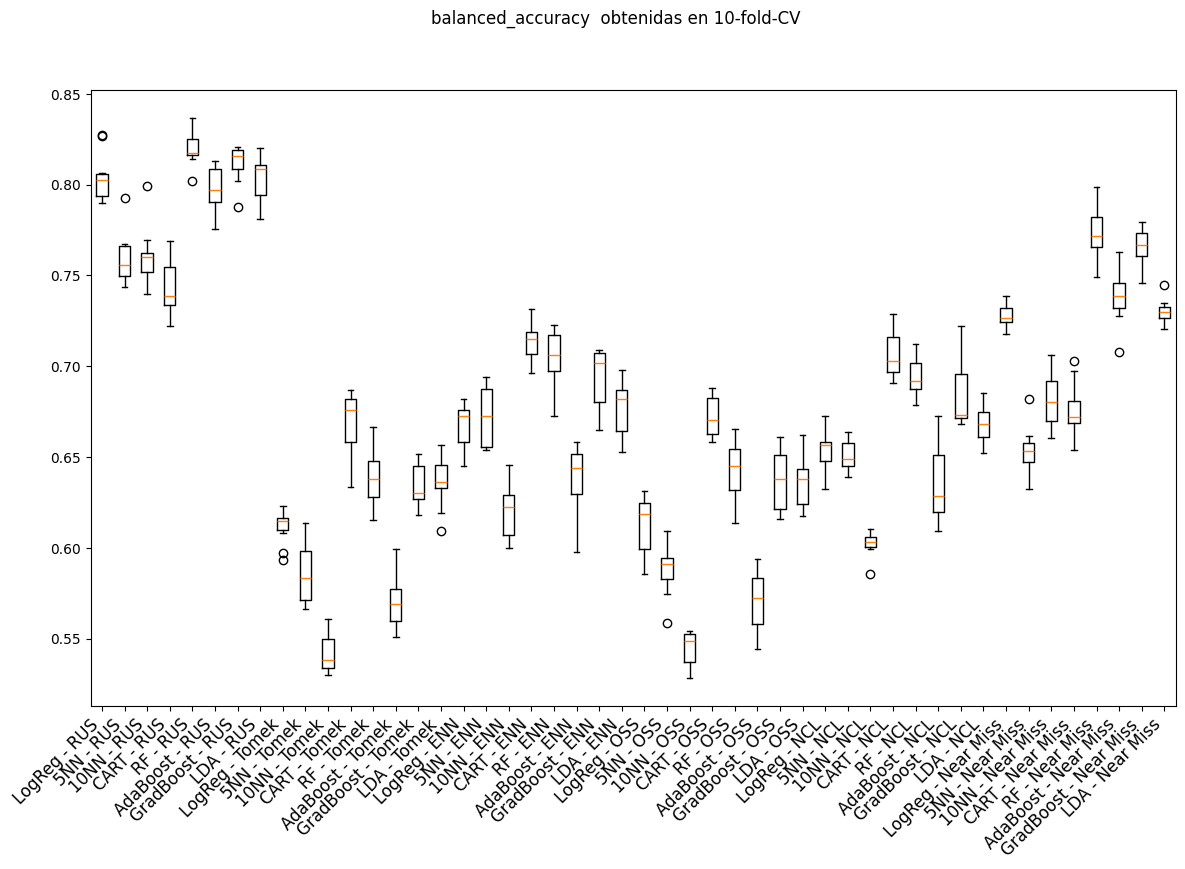

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_under)
ax.set_xticklabels(names_under, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_under)
plt.show()

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1)
model.fit(X_rus, y_rus)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8290897880891487

Matriz de Confusión:
[[9273 2151]
 [ 113  623]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     11424
         1.0       0.22      0.85      0.35       736

    accuracy                           0.81     12160
   macro avg       0.61      0.83      0.62     12160
weighted avg       0.94      0.81      0.86     12160



# **EVALUACIÓN DE MODELOS**

La mejor combinación de algoritmo + sobremuestreo fue Random Forest (RF) + Random Over Sampler con valores de balanced accuracy de 0.99 -> muy cercano a 1; no obstante, ese rendimiento se ve limitado solo a la data de train, ya que al entrenar el modelo con la data de validación, el rendimiento baja a 0.66 aproximadamente.

Por otro lado, la mejor combinación de algoritmo + submuestreo fue Random Forest (RF) + Random Under Sampler con valores de balanced accuracy de 0.82; no obstante, a diferencia del modelo con sobremuestreo, no se vió una disminución del Balanced Accuracy con la data de validación.

Analizando los recall por clase de ambos modelos, se puede observar que el modelo con submuestreo presenta mejores resultados en recall para la clase minoritaria (1: sí hay precipitación). Esto quiere decir que este modelo es más útil para el contexto brindado, ya que es más costoso un falso negativo que un falso positivo. Además que el rendimiento en cuanto a recall empeora para la clase mayoritaria, pero no lo suficiente para decir que es un mal modelo (0.81).

En cocnlusión, comparando los recall para la clase 1, se prefiere el segundo modelo ya que resulta en un 0.85 de recall, frente a 0.33 del otro modelo.

# **Pruebas adicionales**
Ante estos resultados surgen las siguientes incógnitas:

1. ¿Mejorará el primer modelo con sobremuestreo aplicando pesos a las clases? ¿Cuál sería el mejor peso? ¿Sería suficiente para superar al segundo modelo?

2. ¿El escalamiento de los datos tendrá algún efecto de mejora?

3. ¿Obtendríamos los mismos resultados si el dataset tuviera menos datos? ¿Se mantendría la preferencia de submuestreo frente a sobremuestreo? Esta pregunta surge a partir de que el método de Random Under Sampling elimina aleatoriamente registros de la clase mayoritaria hasta que la data esté balanceada con la clase minoritaria, por lo que se cree que se pierde data relevante para el modelo. No obstante aún con la reducción de RUS, aún se cuenta con una cantidad representativa de datos para ambas clases: aproximadamente 3000 por clase. Pero podrían haber efectos distintos en caso se elimine hasta tener un número menor de por ejemplo solo 30 registros.

## Probando pesos

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight='balanced')
# Solo para modelos que usan gradiente se puede hacer lo de class_weight
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6593270460358056

Matriz de Confusión:
[[11277   147]
 [  492   244]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     11424
         1.0       0.62      0.33      0.43       736

    accuracy                           0.95     12160
   macro avg       0.79      0.66      0.70     12160
weighted avg       0.94      0.95      0.94     12160



In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
pesos = {0: 1, 1: 13.25}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
# Solo para modelos que usan gradiente se puede hacer lo de class_weight
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6502976190476191

Matriz de Confusión:
[[11288   136]
 [  506   230]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     11424
         1.0       0.63      0.31      0.42       736

    accuracy                           0.95     12160
   macro avg       0.79      0.65      0.69     12160
weighted avg       0.94      0.95      0.94     12160



In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
pesos = {0: 1, 1: 0.04}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
# Solo para modelos que usan gradiente se puede hacer lo de class_weight
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6971973572037511

Matriz de Confusión:
[[11242   182]
 [  434   302]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     11424
         1.0       0.62      0.41      0.50       736

    accuracy                           0.95     12160
   macro avg       0.79      0.70      0.73     12160
weighted avg       0.94      0.95      0.94     12160



Conclusión para la primera pregunta: Se logra aumentar el rendimiento del modelo para clasificar bien la clase minoritaria, se ve un aumento de 0.08 para el recall de la clase minoritaria, mientras que el de la clase mayoritaria solo disminuye en 0.01, siendo aceptada esta mejora.

Así mismo se prueban pesos para RF + RUS, en esta ocasión se obtuvo una mejora en el rendimiento para la clase 1 de 0.03 en recall, perdiendo la misma cantidad para la clase 0.

In [27]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
pesos = {0: 1, 1: 0.05}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
model.fit(X_rus, y_rus)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8261992296918768

Matriz de Confusión:
[[8881 2543]
 [  92  644]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87     11424
         1.0       0.20      0.88      0.33       736

    accuracy                           0.78     12160
   macro avg       0.60      0.83      0.60     12160
weighted avg       0.94      0.78      0.84     12160



## Probando escalamientos

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

# Definimos el pool de pipleines de ML (MinMaxScaler + algoritmo de ML) a evaluar
pipelines = []
pipelines.append(('LogReg', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear'))))
pipelines.append(('5NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('10NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10))))
pipelines.append(('CART', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=None))))
pipelines.append(('SVM', make_pipeline(MinMaxScaler(), SVC())))
pipelines.append(('RF', make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None))))
pipelines.append(("AdaBoost", make_pipeline(MinMaxScaler(), AdaBoostClassifier(n_estimators=60 , random_state=seed))))
pipelines.append(("GradBoost", make_pipeline(MinMaxScaler(), GradientBoostingClassifier(n_estimators=60, random_state=7))))
pipelines.append(("LDA", make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())))

In [ ]:
# Evaluamos cada pipeline de ML en estrategia de 10-fold-CV
results_pipe = []
names_pipe = []

# genera el particionamiento de 10 folds que seran usados en cada evaluacion
seed = 7
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # especifica el particionador de datos a 10-folds CV

print("\nROS:")
#  evalua cada pipeline en crosvalidacion: combinación RF + ROS
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_res_ros, y_res_ros, cv=kfold, scoring='balanced_accuracy')
    results_pipe.append(cv_results)
    names_pipe.append(pipelinename + ' - ROS')
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))

print("\nRUS:")
#  evalua cada pipeline en crosvalidacion: combinación RF + RUS
for pipelinename, pipeline in pipelines:
    cv_results = cross_val_score(pipeline, X_rus, y_rus, cv=kfold, scoring='balanced_accuracy')
    results_pipe.append(cv_results)
    names_pipe.append(pipelinename + ' - RUS')
    print("{}: {} ({})".format(pipelinename, cv_results.mean(), cv_results.std()))


ROS:
LogReg: 0.8115314930313053 (0.002726768466547559)
5NN: 0.9439539737027731 (0.0021950657921356257)
10NN: 0.9151131804474406 (0.003663030877247917)
CART: 0.977822676422645 (0.0015380264104823058)
SVM: 0.8451678998218497 (0.004349350511128904)
RF: 0.9928696596457323 (0.0011308852846649091)
AdaBoost: 0.8102059180505755 (0.003761255106594625)
GradBoost: 0.8336398146108801 (0.004046383503847059)
LDA: 0.8084485036341003 (0.002823415431050796)

RUS:
LogReg: 0.7983214690042552 (0.01254823351032941)
5NN: 0.7453266785262561 (0.01434399426142946)
10NN: 0.7575766110153188 (0.015253950968678653)
CART: 0.7486030341305753 (0.010348585520371422)
SVM: 0.8080828639851679 (0.012081124901965796)
RF: 0.820102965375353 (0.008496536812618194)
AdaBoost: 0.7995733050177076 (0.011061426157329959)
GradBoost: 0.8094763464128159 (0.008618296255621036)
LDA: 0.8038858927812358 (0.012019703270020988)


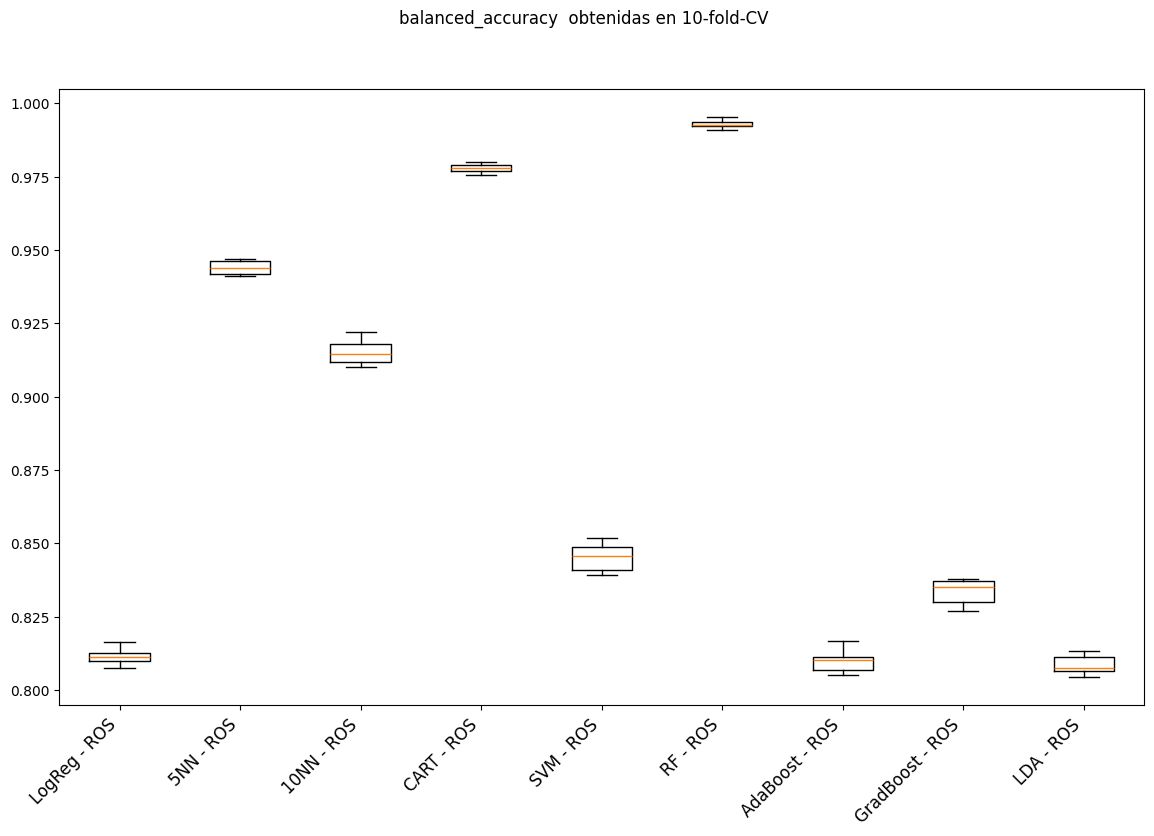

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_pipe[:9])
ax.set_xticklabels(names_pipe[:9], rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_pipe[:9])
plt.show()

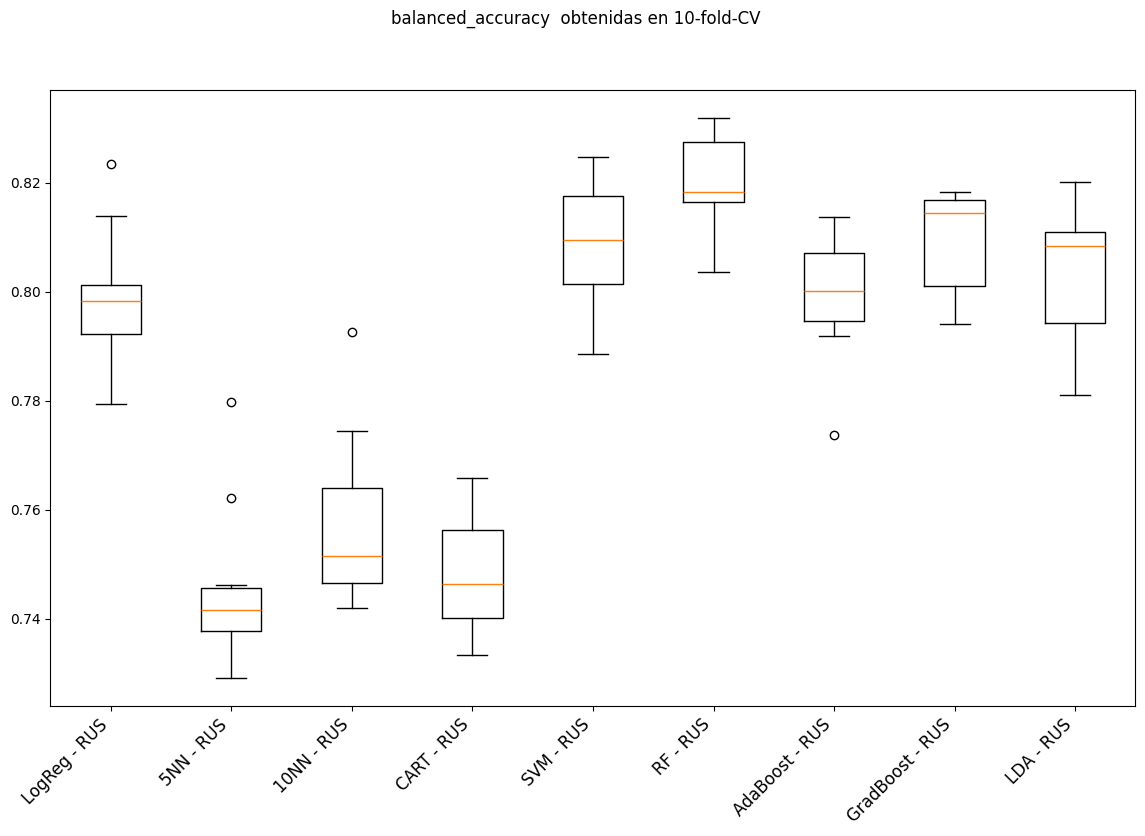

In [ ]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_pipe[9:])
ax.set_xticklabels(names_pipe[9:], rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_pipe[9:])
plt.show()

Volvieron a ganar las combinaciones de RF + ROS y RF + RUS. Se procede a entrenar los modelos.

In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ROS
model = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None))

model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.6667123371087565

Matriz de Confusión:
[[11275   149]
 [  481   255]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     11424
         1.0       0.63      0.35      0.45       736

    accuracy                           0.95     12160
   macro avg       0.80      0.67      0.71     12160
weighted avg       0.94      0.95      0.94     12160



In [ ]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con RUS
model = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None))
model.fit(X_rus, y_rus)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8278623949579832

Matriz de Confusión:
[[9276 2148]
 [ 115  621]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89     11424
         1.0       0.22      0.84      0.35       736

    accuracy                           0.81     12160
   macro avg       0.61      0.83      0.62     12160
weighted avg       0.94      0.81      0.86     12160



Conclusión: No existe mejora con escaladores.

## Para responder a la última pregunta se efectuarán ltodas las pruebas de nuevo.

Verificando la proporción original del dataset

In [10]:
# muestra la distribucion de las clases
print(df.groupby('RR').size())

RR
0.0    57004
1.0     3793
dtype: int64


Reducción del dataset a un 10% por clase de forma aleatoria.

In [11]:
# Fracción del dataset
fraccion = 0.1

# Aplica muestreo aleatorio por clase
df_sampled = df.groupby('RR', group_keys=False).apply(lambda x: x.sample(frac=fraccion, random_state=42))

# Mostrar distribución resultante
print(df_sampled['RR'].value_counts())

RR
0.0    5700
1.0     379
Name: count, dtype: int64


/tmp/ipython-input-11-1486416404.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('RR', group_keys=False).apply(lambda x: x.sample(frac=fraccion, random_state=42))


In [12]:
X = df_sampled.drop(columns='RR')  # atributos
y = df_sampled['RR']    # target

# realiza el train-test split
vadid_fraction = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 4863 ejemplos. Validation: 1216 ejemplos


In [13]:
# ----- SOBREMUESTREO -----

# SMOTE
smote = SMOTE(random_state=seed)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)

# Borderline-SMOTE
borderline = BorderlineSMOTE(random_state=seed, kind='borderline-1')
X_res_bsmote, y_res_bsmote = borderline.fit_resample(X_train, y_train)

# ADASYN
adasyn = ADASYN(random_state=seed)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train, y_train)

# Random Oversampling
ros = RandomOverSampler(random_state=seed)
X_res_ros, y_res_ros = ros.fit_resample(X_train, y_train)

# SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X_train, y_train)

# ----- SUBMUESTREO -----

# Random UnderSampler
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Tomek Links
tomek = TomekLinks()
X_res_tomek, y_res_tomek = tomek.fit_resample(X_train, y_train)

# Edited Nearest Neighbors
enn = EditedNearestNeighbours(n_neighbors=3)
X_res_enn, y_res_enn = enn.fit_resample(X_train, y_train)

# One-Sided Selection (OSS)
oss = OneSidedSelection(random_state=seed)
X_train_OSS, y_train_OSS = oss.fit_resample(X_train, y_train)

# Neighborhood Cleaning Rule (NCL)
ncl = NeighbourhoodCleaningRule()
X_train_ncl, y_train_ncl = ncl.fit_resample(X_train, y_train)

# NearMiss
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X_train, y_train)

# ----- PRINT DE RESULTADOS -----

print("Tamaños tras resampling:")
print("SMOTE:", X_res_smote.shape, dict(Counter(y_res_smote)))
print("Borderline-SMOTE:", X_res_bsmote.shape, dict(Counter(y_res_bsmote)))
print("ADASYN:", X_res_adasyn.shape, dict(Counter(y_res_adasyn)))
print("Random Oversampling:", X_res_ros.shape, dict(Counter(y_res_ros)))
print("SVMSMOTE:", X_svm_smote.shape, dict(Counter(y_svm_smote)))

print("Random UnderSampler:", X_rus.shape, dict(Counter(y_rus)))
print("Tomek Links:", X_res_tomek.shape, dict(Counter(y_res_tomek)))
print("Edited Nearest Neighbors (ENN):", X_res_enn.shape, dict(Counter(y_res_enn)))
print("One-Sided Selection (OSS):", X_train_OSS.shape, dict(Counter(y_train_OSS)))
print("Neighborhood Cleaning Rule (NCL):", X_train_ncl.shape, dict(Counter(y_train_ncl)))
print("NearMiss:", X_nearmiss.shape, dict(Counter(y_nearmiss)))


Tamaños tras resampling:
SMOTE: (9100, 14) {0.0: 4550, 1.0: 4550}
Borderline-SMOTE: (9100, 14) {0.0: 4550, 1.0: 4550}
ADASYN: (9137, 14) {0.0: 4550, 1.0: 4587}
Random Oversampling: (9100, 14) {0.0: 4550, 1.0: 4550}
SVMSMOTE: (9100, 14) {0.0: 4550, 1.0: 4550}
Random UnderSampler: (626, 14) {0.0: 313, 1.0: 313}
Tomek Links: (4745, 14) {0.0: 4432, 1.0: 313}
Edited Nearest Neighbors (ENN): (4310, 14) {0.0: 3997, 1.0: 313}
One-Sided Selection (OSS): (4739, 14) {0.0: 4426, 1.0: 313}
Neighborhood Cleaning Rule (NCL): (4293, 14) {0.0: 3980, 1.0: 313}
NearMiss: (626, 14) {0.0: 313, 1.0: 313}


In [17]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))    #Esto es el accuracy

LogReg: 0.5944419277444666 (0.02224685304849713)
5NN: 0.5480583389540568 (0.02264012247644573)
10NN: 0.5143266995990396 (0.011425194358188265)
CART: 0.6403766610244553 (0.031789283380809163)
RF: 0.5836795567899873 (0.027767391210743984)
AdaBoost: 0.5614644573229359 (0.018226368119496995)
GradBoost: 0.6111299192002803 (0.032781102383169565)
LDA: 0.6135314134158756 (0.03749584515456526)


In [18]:
results_over = []
names_over = []
print("Smote:")
for algoname, algo in algos:
    cv_results1 = cross_val_score(algo, X_res_smote, y_res_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results1)
    names_over.append(algoname + ' - Smote')
    print("{}: {} ({})".format(algoname, cv_results1.mean(), cv_results1.std()))

print("\nBorderline-Smote:")
for algoname, algo in algos:
    cv_results2 = cross_val_score(algo, X_res_bsmote, y_res_bsmote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results2)
    names_over.append(algoname + ' - Borderline-Smote:')
    print("{}: {} ({})".format(algoname, cv_results2.mean(), cv_results2.std()))

print("\nADASYN:")
for algoname, algo in algos:
    cv_results3 = cross_val_score(algo, X_res_adasyn, y_res_adasyn, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results3)
    names_over.append(f"{algoname} - ADASYN")
    print(f"{algoname}: {cv_results3.mean()} ({cv_results3.std()})")

print("\nRandomOverSampler:")
for algoname, algo in algos:
    cv_results4 = cross_val_score(algo, X_res_ros, y_res_ros, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results4)
    names_over.append(f"{algoname} - ROS")
    print(f"{algoname}: {cv_results4.mean()} ({cv_results4.std()})")

print("\nSVSMOTE:")
for algoname, algo in algos:
    cv_results5 = cross_val_score(algo, X_svm_smote, y_svm_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results5)
    names_over.append(f"{algoname} - SVSMOTE")
    print("{}: {} ({})".format(algoname, cv_results5.mean(), cv_results5.std()))

Smote:
LogReg: 0.8276906230448045 (0.014428311051424591)
5NN: 0.90310996981676 (0.008988370688125092)
10NN: 0.8859179750645542 (0.011427246632896048)
CART: 0.938374114493638 (0.01001939632372995)
RF: 0.9760220372531417 (0.004505638603551729)
AdaBoost: 0.9018165256944408 (0.011095295972736074)
GradBoost: 0.945574043010955 (0.007134242589750306)
LDA: 0.827574306294974 (0.013752486789215607)

Borderline-Smote:
LogReg: 0.8599321604813912 (0.008166234294990055)
5NN: 0.9257307114142753 (0.009935163988871436)
10NN: 0.9115124005057853 (0.007454821822674826)
CART: 0.9414721430027525 (0.010050714285163777)
RF: 0.9746710674796034 (0.00376361342465573)
AdaBoost: 0.9125805444441923 (0.00953763782346101)
GradBoost: 0.9445821327731112 (0.006939068806619513)
LDA: 0.8600593467821384 (0.010322450235627044)

ADASYN:
LogReg: 0.8169890933745834 (0.015468099575695286)
5NN: 0.8984489388743041 (0.009557789473516189)
10NN: 0.8826161219039204 (0.007886098010890033)
CART: 0.9418475477571384 (0.00925030426164224)

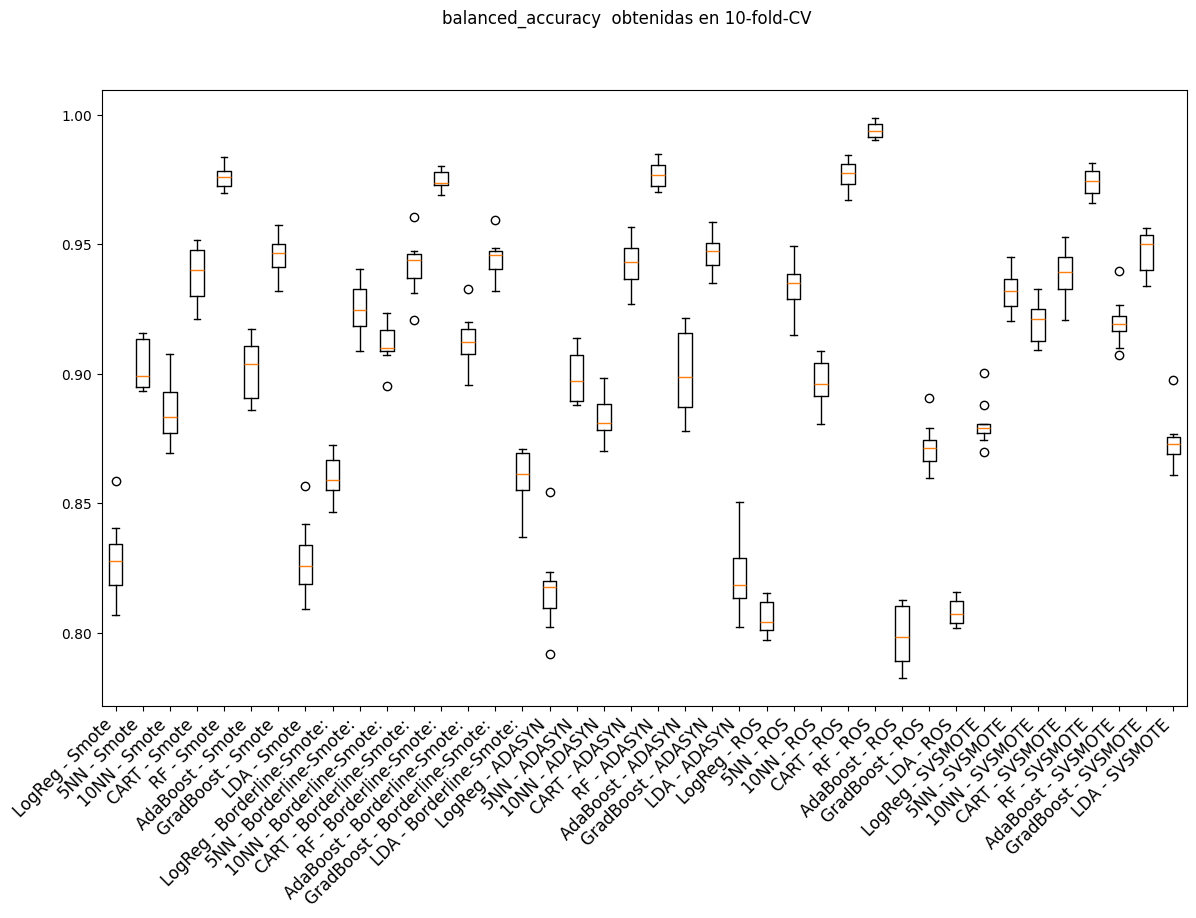

In [19]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_over)
plt.show()

La mejor combinación fue RF + ROS

In [20]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ROS
pesos = {0: 1, 1:0.05}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.686969696969697

Matriz de Confusión:
[[1127   23]
 [  40   26]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      1150
         1.0       0.53      0.39      0.45        66

    accuracy                           0.95      1216
   macro avg       0.75      0.69      0.71      1216
weighted avg       0.94      0.95      0.94      1216



In [21]:
results_under = []
names_under = []
print("RUS:")
for algoname, algo in algos:
    cv_results_rus = cross_val_score(algo, X_rus, y_rus, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_rus)
    names_under.append(f"{algoname} - RUS")
    print("{}: {} ({})".format(algoname, cv_results_rus.mean(), cv_results_rus.std()))

print("\nTomek Links:")
for algoname, algo in algos:
    cv_results_tomek = cross_val_score(algo, X_res_tomek, y_res_tomek, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_tomek)
    names_under.append(f"{algoname} - Tomek")
    print("{}: {} ({})".format(algoname, cv_results_tomek.mean(), cv_results_tomek.std()))

print("\nENN:")
for algoname, algo in algos:
    cv_results_enn = cross_val_score(algo, X_res_enn, y_res_enn, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_enn)
    names_under.append(f"{algoname} - ENN")
    print("{}: {} ({})".format(algoname, cv_results_enn.mean(), cv_results_enn.std()))

print("\nOSS:")
for algoname, algo in algos:
    cv_results_oss = cross_val_score(algo, X_train_OSS, y_train_OSS, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_oss)
    names_under.append(f"{algoname} - OSS")
    print("{}: {} ({})".format(algoname, cv_results_oss.mean(), cv_results_oss.std()))

print("\nNCL:")
for algoname, algo in algos:
    cv_results_ncl = cross_val_score(algo, X_train_ncl, y_train_ncl, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_ncl)
    names_under.append(f"{algoname} - NCL")
    print("{}: {} ({})".format(algoname, cv_results_ncl.mean(), cv_results_ncl.std()))

print("\nNear Miss:")
for algoname, algo in algos:
    cv_results_near_miss = cross_val_score(algo, X_nearmiss, y_nearmiss, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_near_miss)
    names_under.append(f"{algoname} - Near Miss")
    print("{}: {} ({})".format(algoname, cv_results_near_miss.mean(), cv_results_near_miss.std()))

RUS:
LogReg: 0.7947425723046101 (0.058696082823116835)
5NN: 0.7059706240868725 (0.03741179032344724)
10NN: 0.7045962307645837 (0.04881020835944967)
CART: 0.7110982255782852 (0.05190056201162319)
RF: 0.7647230301038249 (0.03329729926320211)
AdaBoost: 0.7649728193232412 (0.04298695768043405)
GradBoost: 0.7776060568645671 (0.026838954396988187)
LDA: 0.8016556290604455 (0.04000323818555821)

Tomek Links:
LogReg: 0.6043942637152083 (0.020705736796451695)
5NN: 0.5526220444101011 (0.03493014392394299)
10NN: 0.512061480637592 (0.01451440351377835)
CART: 0.6402385109037694 (0.03689896828495222)
RF: 0.5919097222291522 (0.02289848087140401)
AdaBoost: 0.5697631399308961 (0.012390391959618672)
GradBoost: 0.6459964352556159 (0.03765090878086258)
LDA: 0.6227690311618468 (0.029049779789981973)

ENN:
LogReg: 0.6448730872403827 (0.042354515558192314)
5NN: 0.6216765292184768 (0.033621880410606195)
10NN: 0.5660808026152705 (0.03160659661720332)
CART: 0.6939542744468788 (0.037935794855107)
RF: 0.6379702553

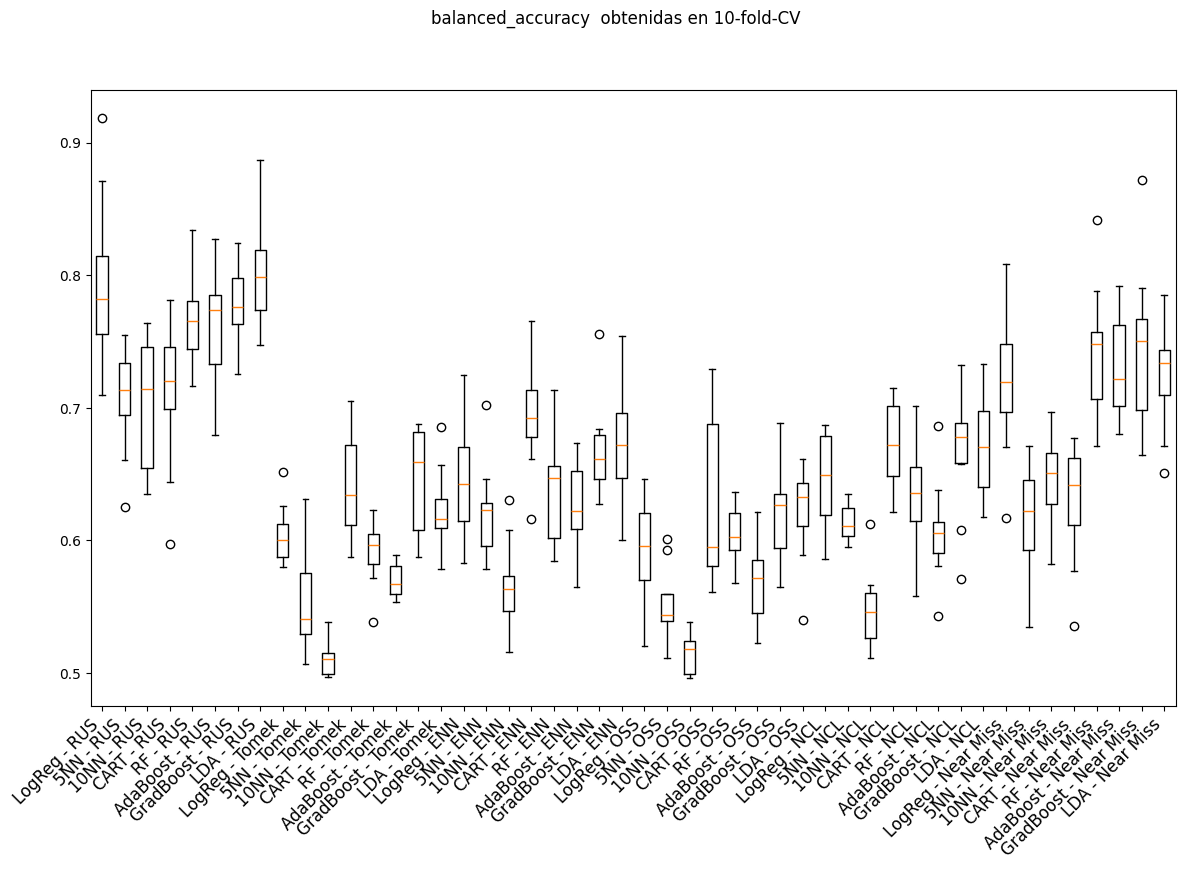

In [22]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_under)
ax.set_xticklabels(names_under, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_under)
plt.show()

In [23]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ENN
model = LinearDiscriminantAnalysis()
model.fit(X_rus, y_rus)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.8328063241106719

Matriz de Confusión:
[[870 280]
 [  6  60]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1150
         1.0       0.18      0.91      0.30        66

    accuracy                           0.76      1216
   macro avg       0.58      0.83      0.58      1216
weighted avg       0.95      0.76      0.83      1216



In [24]:
# Fracción del dataset
fraccion = 0.02

# Aplica muestreo aleatorio por clase
df_sampled = df.groupby('RR', group_keys=False).apply(lambda x: x.sample(frac=fraccion, random_state=42))

# Mostrar distribución resultante
print(df_sampled['RR'].value_counts())

RR
0.0    1140
1.0      76
Name: count, dtype: int64


/tmp/ipython-input-24-4237074233.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('RR', group_keys=False).apply(lambda x: x.sample(frac=fraccion, random_state=42))


In [25]:
X = df_sampled.drop(columns='RR')  # atributos
y = df_sampled['RR']    # target

# realiza el train-test split
vadid_fraction = 0.20    # proporcion de muestras para validacion
seed = 7   # semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print('Training: %d ejemplos. Validation: %d ejemplos' % (len(y_train), len(y_valid)))

Training: 972 ejemplos. Validation: 244 ejemplos


In [26]:
# ----- SOBREMUESTREO -----

# SMOTE
smote = SMOTE(random_state=seed)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)

# Borderline-SMOTE
borderline = BorderlineSMOTE(random_state=seed, kind='borderline-1')
X_res_bsmote, y_res_bsmote = borderline.fit_resample(X_train, y_train)

# ADASYN
adasyn = ADASYN(random_state=seed)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X_train, y_train)

# Random Oversampling
ros = RandomOverSampler(random_state=seed)
X_res_ros, y_res_ros = ros.fit_resample(X_train, y_train)

# SVMSMOTE
svm_smote = SVMSMOTE(random_state=seed)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X_train, y_train)

# ----- SUBMUESTREO -----

# Random UnderSampler
rus = RandomUnderSampler(random_state=seed)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Tomek Links
tomek = TomekLinks()
X_res_tomek, y_res_tomek = tomek.fit_resample(X_train, y_train)

# Edited Nearest Neighbors
enn = EditedNearestNeighbours(n_neighbors=3)
X_res_enn, y_res_enn = enn.fit_resample(X_train, y_train)

# One-Sided Selection (OSS)
oss = OneSidedSelection(random_state=seed)
X_train_OSS, y_train_OSS = oss.fit_resample(X_train, y_train)

# Neighborhood Cleaning Rule (NCL)
ncl = NeighbourhoodCleaningRule()
X_train_ncl, y_train_ncl = ncl.fit_resample(X_train, y_train)

# NearMiss
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = nearmiss.fit_resample(X_train, y_train)

# ----- PRINT DE RESULTADOS -----

print("Tamaños tras resampling:")
print("SMOTE:", X_res_smote.shape, dict(Counter(y_res_smote)))
print("Borderline-SMOTE:", X_res_bsmote.shape, dict(Counter(y_res_bsmote)))
print("ADASYN:", X_res_adasyn.shape, dict(Counter(y_res_adasyn)))
print("Random Oversampling:", X_res_ros.shape, dict(Counter(y_res_ros)))
print("SVMSMOTE:", X_svm_smote.shape, dict(Counter(y_svm_smote)))

print("Random UnderSampler:", X_rus.shape, dict(Counter(y_rus)))
print("Tomek Links:", X_res_tomek.shape, dict(Counter(y_res_tomek)))
print("Edited Nearest Neighbors (ENN):", X_res_enn.shape, dict(Counter(y_res_enn)))
print("One-Sided Selection (OSS):", X_train_OSS.shape, dict(Counter(y_train_OSS)))
print("Neighborhood Cleaning Rule (NCL):", X_train_ncl.shape, dict(Counter(y_train_ncl)))
print("NearMiss:", X_nearmiss.shape, dict(Counter(y_nearmiss)))


Tamaños tras resampling:
SMOTE: (1820, 14) {0.0: 910, 1.0: 910}
Borderline-SMOTE: (1820, 14) {0.0: 910, 1.0: 910}
ADASYN: (1837, 14) {0.0: 910, 1.0: 927}
Random Oversampling: (1820, 14) {0.0: 910, 1.0: 910}
SVMSMOTE: (1820, 14) {0.0: 910, 1.0: 910}
Random UnderSampler: (124, 14) {0.0: 62, 1.0: 62}
Tomek Links: (944, 14) {0.0: 882, 1.0: 62}
Edited Nearest Neighbors (ENN): (854, 14) {0.0: 792, 1.0: 62}
One-Sided Selection (OSS): (920, 14) {0.0: 858, 1.0: 62}
Neighborhood Cleaning Rule (NCL): (870, 14) {0.0: 808, 1.0: 62}
NearMiss: (124, 14) {0.0: 62, 1.0: 62}


In [27]:
# Evaluamos cada algoritmo de ML en estrategia de 10-fold-CV
results = []
names = []

#  evalua cada algoritmo de ML
for algoname, algo in algos:
    cv_results = cross_val_score(algo, X_train, y_train, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algoname)
    print("{}: {} ({})".format(algoname, cv_results.mean(), cv_results.std()))    #Esto es el accuracy

LogReg: 0.6441882250364179 (0.09543824555120094)
5NN: 0.5575331217370039 (0.06661352010086061)
10NN: 0.5349999999999999 (0.056984403324262516)
CART: 0.6810850048551564 (0.09211731722463162)
RF: 0.5917087424029921 (0.08775512208222633)
AdaBoost: 0.6455593171156357 (0.11696578560734792)
GradBoost: 0.6504195380003891 (0.09945448791749908)
LDA: 0.6625258338572649 (0.08521455617467892)


In [28]:
results_over = []
names_over = []
print("Smote:")
for algoname, algo in algos:
    cv_results1 = cross_val_score(algo, X_res_smote, y_res_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results1)
    names_over.append(algoname + ' - Smote')
    print("{}: {} ({})".format(algoname, cv_results1.mean(), cv_results1.std()))

print("\nBorderline-Smote:")
for algoname, algo in algos:
    cv_results2 = cross_val_score(algo, X_res_bsmote, y_res_bsmote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results2)
    names_over.append(algoname + ' - Borderline-Smote:')
    print("{}: {} ({})".format(algoname, cv_results2.mean(), cv_results2.std()))

print("\nADASYN:")
for algoname, algo in algos:
    cv_results3 = cross_val_score(algo, X_res_adasyn, y_res_adasyn, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results3)
    names_over.append(f"{algoname} - ADASYN")
    print(f"{algoname}: {cv_results3.mean()} ({cv_results3.std()})")

print("\nRandomOverSampler:")
for algoname, algo in algos:
    cv_results4 = cross_val_score(algo, X_res_ros, y_res_ros, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results4)
    names_over.append(f"{algoname} - ROS")
    print(f"{algoname}: {cv_results4.mean()} ({cv_results4.std()})")

print("\nSVSMOTE:")
for algoname, algo in algos:
    cv_results5 = cross_val_score(algo, X_svm_smote, y_svm_smote, cv=kfold, scoring='balanced_accuracy')
    results_over.append(cv_results5)
    names_over.append(f"{algoname} - SVSMOTE")
    print("{}: {} ({})".format(algoname, cv_results5.mean(), cv_results5.std()))

Smote:
LogReg: 0.8566620841250122 (0.023872959423778886)
5NN: 0.9022927664764367 (0.01654647114890619)
10NN: 0.8874075790857677 (0.020782169413570355)
CART: 0.9309875426822002 (0.013236064964732515)
RF: 0.9704123839890844 (0.01355938543460855)
AdaBoost: 0.9123188183088832 (0.023688906527358222)
GradBoost: 0.954709851979531 (0.017318812537084668)
LDA: 0.8537051264238349 (0.020817012532298444)

Borderline-Smote:
LogReg: 0.8974600382697083 (0.02362376759474352)
5NN: 0.9227659420351699 (0.019779137330050895)
10NN: 0.9146518990230963 (0.018518059391460017)
CART: 0.9275933624728168 (0.018917737612646396)
RF: 0.9716840109859086 (0.010257047237707498)
AdaBoost: 0.934248647141122 (0.017629172084691766)
GradBoost: 0.9627762688349092 (0.014767720146899296)
LDA: 0.8816265583962964 (0.02424668331920624)

ADASYN:
LogReg: 0.8565581609603263 (0.027105660028896545)
5NN: 0.891142392936709 (0.017637104592836076)
10NN: 0.8746210371034836 (0.01209961977830044)
CART: 0.9330299941964183 (0.015162775416657785

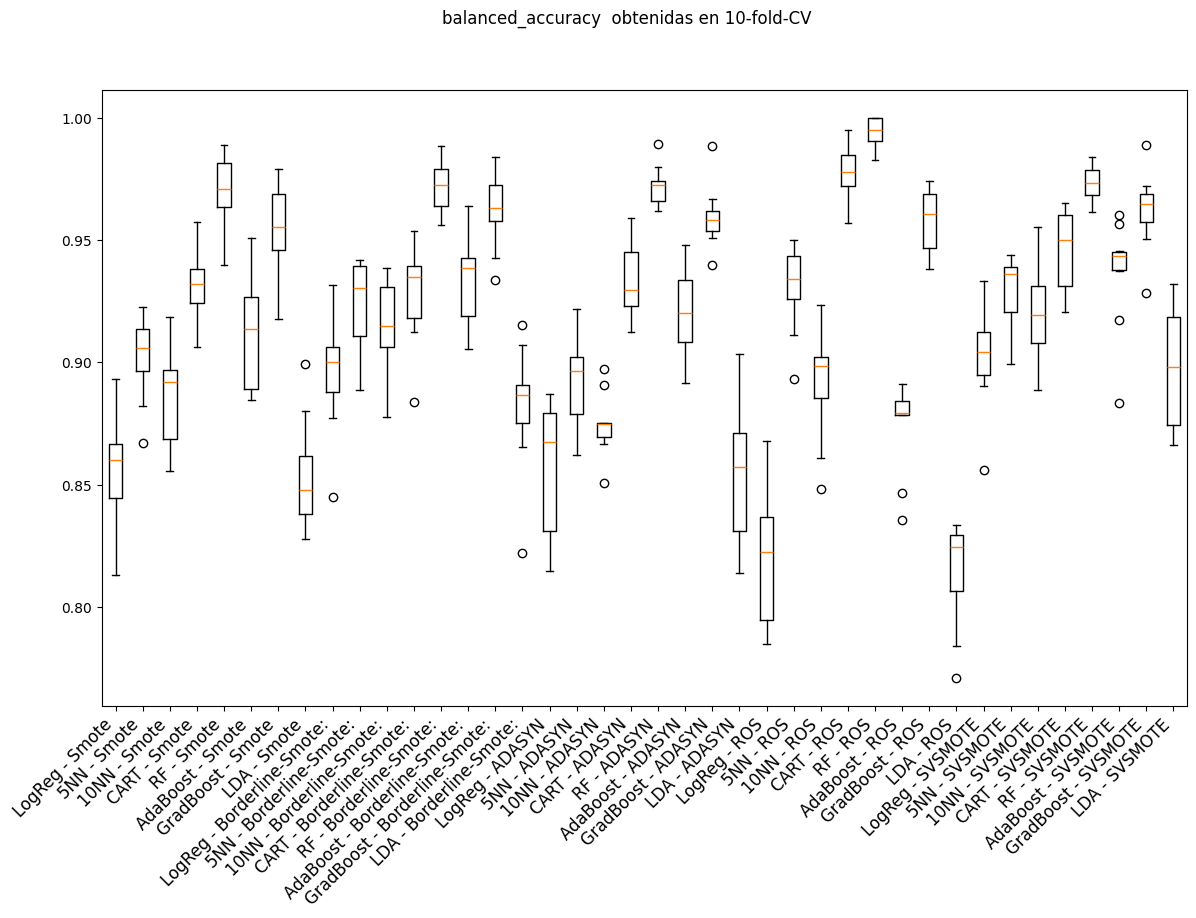

In [29]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_over)
ax.set_xticklabels(names_over, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_over)
plt.show()

In [30]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ROS
pesos = {0: 1, 1:0.05}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
model.fit(X_res_ros, y_res_ros)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.665527950310559

Matriz de Confusión:
[[224   6]
 [  9   5]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       230
         1.0       0.45      0.36      0.40        14

    accuracy                           0.94       244
   macro avg       0.71      0.67      0.68       244
weighted avg       0.93      0.94      0.94       244



In [31]:
results_under = []
names_under = []
print("RUS:")
for algoname, algo in algos:
    cv_results_rus = cross_val_score(algo, X_rus, y_rus, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_rus)
    names_under.append(f"{algoname} - RUS")
    print("{}: {} ({})".format(algoname, cv_results_rus.mean(), cv_results_rus.std()))

print("\nTomek Links:")
for algoname, algo in algos:
    cv_results_tomek = cross_val_score(algo, X_res_tomek, y_res_tomek, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_tomek)
    names_under.append(f"{algoname} - Tomek")
    print("{}: {} ({})".format(algoname, cv_results_tomek.mean(), cv_results_tomek.std()))

print("\nENN:")
for algoname, algo in algos:
    cv_results_enn = cross_val_score(algo, X_res_enn, y_res_enn, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_enn)
    names_under.append(f"{algoname} - ENN")
    print("{}: {} ({})".format(algoname, cv_results_enn.mean(), cv_results_enn.std()))

print("\nOSS:")
for algoname, algo in algos:
    cv_results_oss = cross_val_score(algo, X_train_OSS, y_train_OSS, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_oss)
    names_under.append(f"{algoname} - OSS")
    print("{}: {} ({})".format(algoname, cv_results_oss.mean(), cv_results_oss.std()))

print("\nNCL:")
for algoname, algo in algos:
    cv_results_ncl = cross_val_score(algo, X_train_ncl, y_train_ncl, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_ncl)
    names_under.append(f"{algoname} - NCL")
    print("{}: {} ({})".format(algoname, cv_results_ncl.mean(), cv_results_ncl.std()))

print("\nNear Miss:")
for algoname, algo in algos:
    cv_results_near_miss = cross_val_score(algo, X_nearmiss, y_nearmiss, cv=kfold, scoring='balanced_accuracy')
    results_under.append(cv_results_near_miss)
    names_under.append(f"{algoname} - Near Miss")
    print("{}: {} ({})".format(algoname, cv_results_near_miss.mean(), cv_results_near_miss.std()))

RUS:
LogReg: 0.764404761904762 (0.09347239700717841)
5NN: 0.7320833333333334 (0.11937646545502657)
10NN: 0.714047619047619 (0.09388593697140019)
CART: 0.7105952380952381 (0.1221157609413903)
RF: 0.8004166666666667 (0.14167918362070192)
AdaBoost: 0.7079761904761905 (0.18007309079151967)
GradBoost: 0.7337499999999999 (0.12688657121926777)
LDA: 0.7895833333333333 (0.10013640427662286)

Tomek Links:
LogReg: 0.6393539633340097 (0.08803925201559885)
5NN: 0.5697240210820219 (0.06811386413882607)
10NN: 0.5255555555555554 (0.04068851871911233)
CART: 0.6349939370554525 (0.14071606939400796)
RF: 0.5443801232232529 (0.06554854269261859)
AdaBoost: 0.6625396825396825 (0.10258918162479388)
GradBoost: 0.659618218461348 (0.12240305122540635)
LDA: 0.6647399723041859 (0.10430436280627026)

ENN:
LogReg: 0.710676282235666 (0.13369531686180047)
5NN: 0.5865354493031665 (0.0958914107304981)
10NN: 0.5422222222222223 (0.07282653159188417)
CART: 0.7093001413052207 (0.14548278059732894)
RF: 0.6147309236947791 (0.

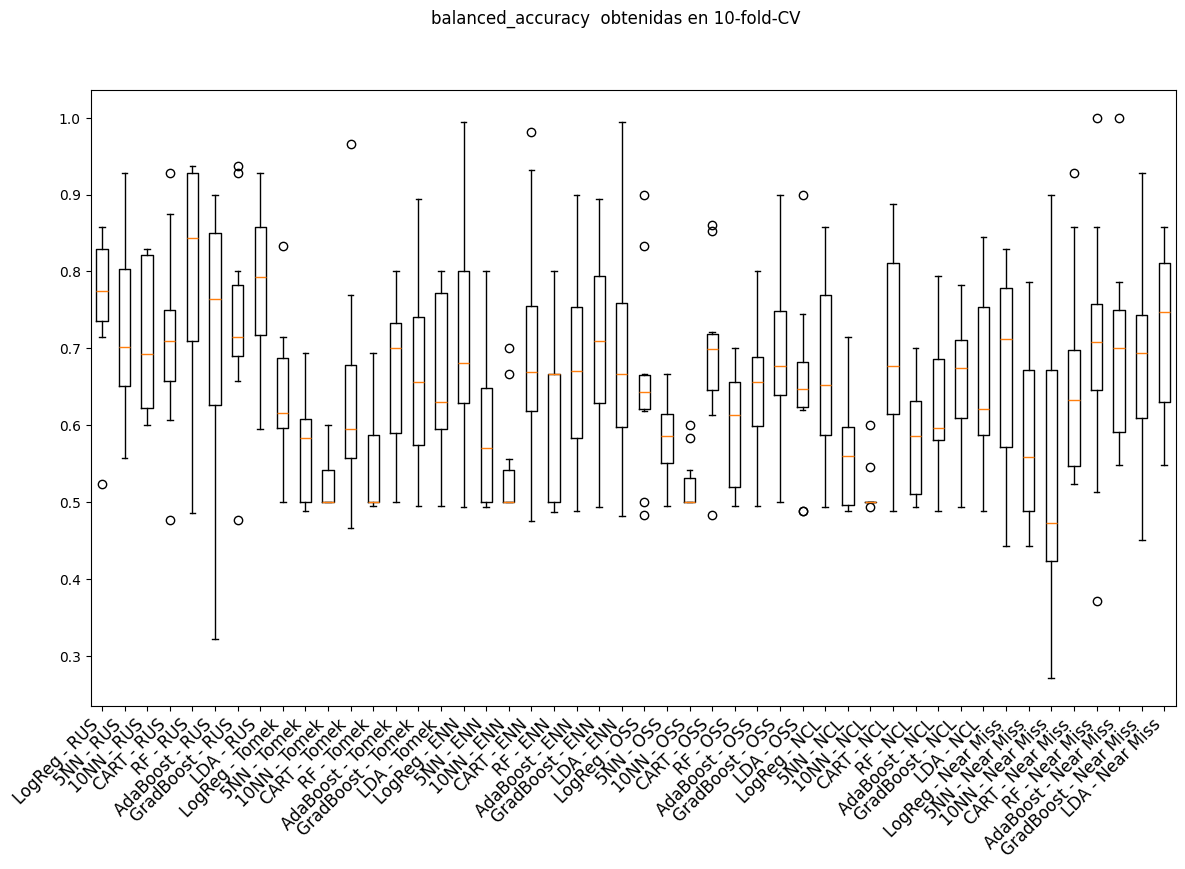

In [32]:
# Muestra graficamente los resultados de balanced_accuracy  en crossvalidacion de los Algoritmos evaluados
fig = plt.figure(figsize=(14, 8))
fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
ax = fig.add_subplot(111)
plt.boxplot(results_under)
ax.set_xticklabels(names_under, rotation=45, ha='right', fontsize=12)
ax.set_xticklabels(names_under)
plt.show()

In [33]:
# Reentrena modelo LR con todos los datos de entrenamiento y lo prueba en el conjunto de validación
# Usamos Random Forest con datos remuestreados con ROS
pesos = {0: 1, 1:0.05}
model = RandomForestClassifier(n_estimators=100, random_state=seed, max_depth=None, n_jobs=-1, class_weight=pesos)
model.fit(X_rus, y_rus)

# predice la c lase del conjunto de validacion
y_predicted = model.predict(X_valid)
print("Balanced Accuracy score:", balanced_accuracy_score(y_valid, y_predicted))

# muestra la matriz de confusion
# en la matriz de confusion, un elemento Cij es el numero de ejemplos predichos como clase j que son realmente de clase i
print("\nMatriz de Confusión:")
print(confusion_matrix(y_valid, y_predicted))

# muestra un reporte de la clasificacion en validacion
print("\nReporte de clasificacion en conjunto de validacion: \n")
print(classification_report(y_valid, y_predicted))

Balanced Accuracy score: 0.7245341614906833

Matriz de Confusión:
[[169  61]
 [  4  10]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

         0.0       0.98      0.73      0.84       230
         1.0       0.14      0.71      0.24        14

    accuracy                           0.73       244
   macro avg       0.56      0.72      0.54       244
weighted avg       0.93      0.73      0.80       244



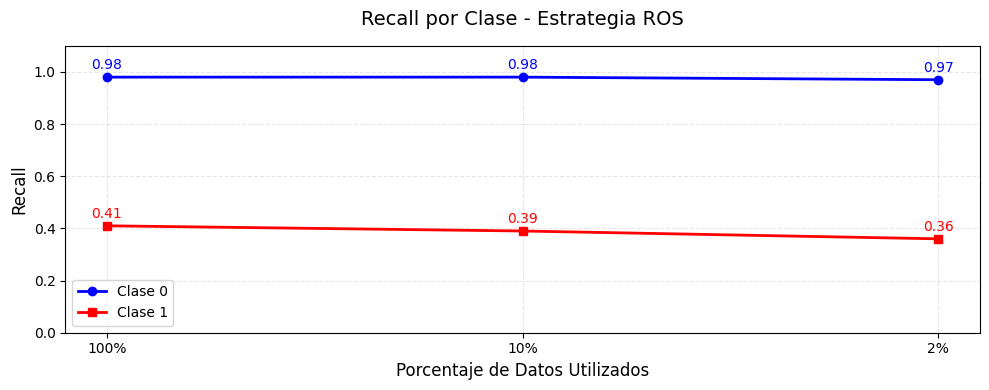

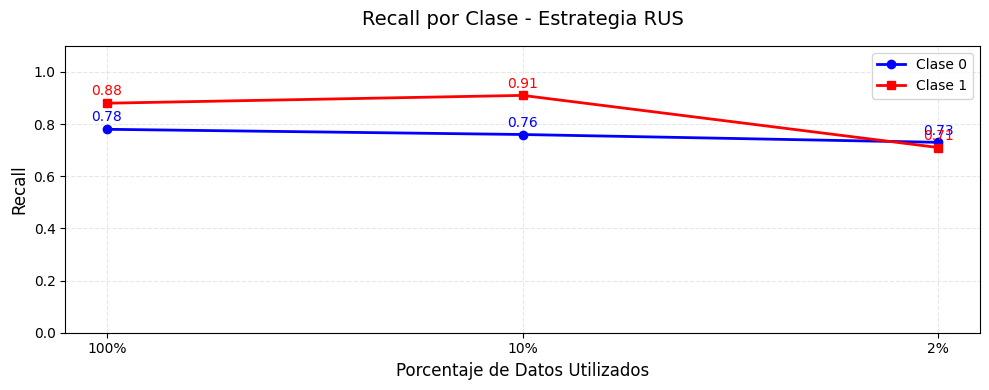

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Datos organizados
porcentajes = ['100%', '10%', '2%']
x = np.arange(len(porcentajes))

# Datos de recall
data = {
    'ROS': {
        'clase0': [0.98, 0.98, 0.97],
        'clase1': [0.41, 0.39, 0.36]
    },
    'RUS': {
        'clase0': [0.78, 0.76, 0.73],
        'clase1': [0.88, 0.91, 0.71]
    }
}

# Configuración común
common_style = {
    'figsize': (10, 4),
    'ylim': (0, 1.1),
    'grid': True,
    'linestyle': '--',
    'alpha': 0.3
}

## Gráfico para ROS
plt.figure(figsize=common_style['figsize'])
plt.plot(x, data['ROS']['clase0'], marker='o', label='Clase 0', color='blue', linewidth=2)
plt.plot(x, data['ROS']['clase1'], marker='s', label='Clase 1', color='red', linewidth=2)

plt.title('Recall por Clase - Estrategia ROS', fontsize=14, pad=15)
plt.xlabel('Porcentaje de Datos Utilizados', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xticks(x, porcentajes)
plt.ylim(common_style['ylim'])
plt.grid(common_style['grid'], linestyle=common_style['linestyle'], alpha=common_style['alpha'])
plt.legend(loc='best')

# Añadir valores
for i in x:
    plt.text(i, data['ROS']['clase0'][i] + 0.03, f"{data['ROS']['clase0'][i]:.2f}", ha='center', color='blue')
    plt.text(i, data['ROS']['clase1'][i] + 0.03, f"{data['ROS']['clase1'][i]:.2f}", ha='center', color='red')

plt.tight_layout()
plt.show()

## Gráfico para RUS
plt.figure(figsize=common_style['figsize'])
plt.plot(x, data['RUS']['clase0'], marker='o', label='Clase 0', color='blue', linewidth=2)
plt.plot(x, data['RUS']['clase1'], marker='s', label='Clase 1', color='red', linewidth=2)

plt.title('Recall por Clase - Estrategia RUS', fontsize=14, pad=15)
plt.xlabel('Porcentaje de Datos Utilizados', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.xticks(x, porcentajes)
plt.ylim(common_style['ylim'])
plt.grid(common_style['grid'], linestyle=common_style['linestyle'], alpha=common_style['alpha'])
plt.legend(loc='best')

# Añadir valores
for i in x:
    plt.text(i, data['RUS']['clase0'][i] + 0.03, f"{data['RUS']['clase0'][i]:.2f}", ha='center', color='blue')
    plt.text(i, data['RUS']['clase1'][i] + 0.03, f"{data['RUS']['clase1'][i]:.2f}", ha='center', color='red')

plt.tight_layout()
plt.show()